## What Kind of Bike Is It?

This model categorizes two Motorcycles: Indian Scout and Honda Shadow Aero.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai fastdownload fastcore duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images

def get_screenshot_urls(search_term, max_images=30):
    print(f"Searching for '{search_term}'")
    return L(ddg_images(search_term, max_results=max_images)).itemgot('image')

In [5]:
from time import sleep
from fastai.vision.utils import download_images
from fastcore.all import *

categories = ['chrysler 300', 'rolls royce phantom']

top_level_path = Path.home()/'data/300-or-phantom'

if not top_level_path.exists():
    top_level_path.mkdir(parents=True)
    for category in categories:
        dest_path = top_level_path/category
        dest_path.mkdir(exist_ok=True)
        urls = get_screenshot_urls(category, 50)
        download_images(dest=dest_path, urls=urls)
        sleep(10)

Searching for 'chrysler 300'
Searching for 'rolls royce phantom'


In [6]:
from fastai.vision.all import *

failed = verify_images(get_image_files(top_level_path))
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

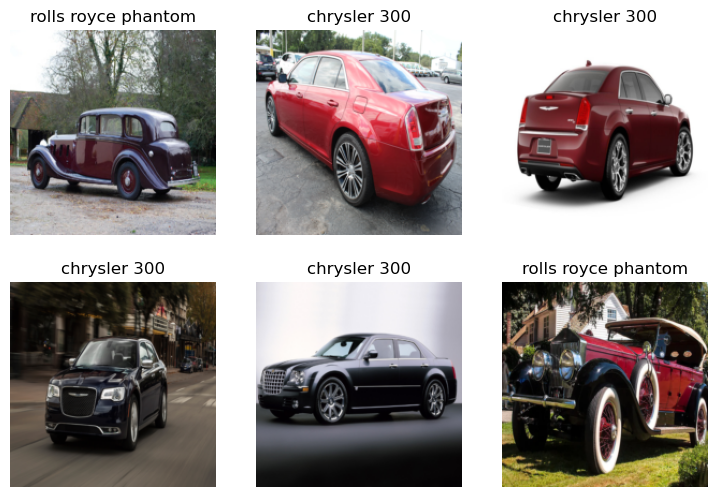

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=parent_label,
    item_tfms=[Resize(192, ResizeMethod.Squish)]
).dataloaders(top_level_path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.817939,1.422854,0.611111,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.779077,1.165230,0.444444,00:02
1,0.557110,1.091904,0.444444,00:02
2,0.458220,1.134424,0.444444,00:02
3,0.380286,0.988843,0.388889,00:02
4,0.308411,0.868275,0.388889,00:02
5,0.256444,0.814357,0.388889,00:02
6,0.216236,0.784767,0.388889,00:02
7,0.187351,0.752725,0.333333,00:02
8,0.163184,0.777305,0.388889,00:02
9,0.144100,0.755601,0.388889,00:02


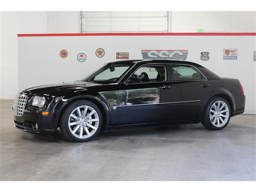

In [13]:
from fastdownload import download_url

test_path = top_level_path/'test.jpg'

image_url = ddg_images('chrysler 300 for sale', max_results=100)[89]['image']
download_url(image_url, test_path)
Image.open(test_path).to_thumb(256,256)

In [14]:
bike_type,_,probability = learn.predict(PILImage.create(test_path))
print(bike_type)
print(f"{probability[0]:.4f}")

chrysler 300
0.6251


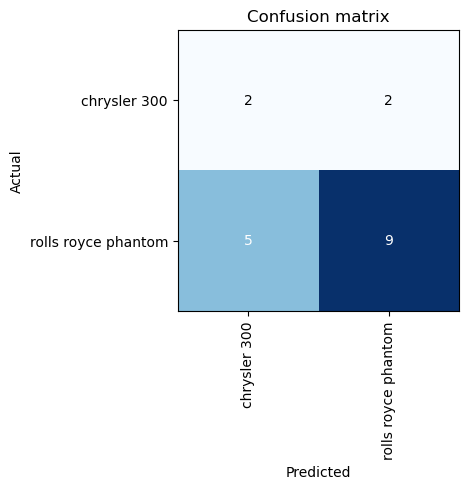

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

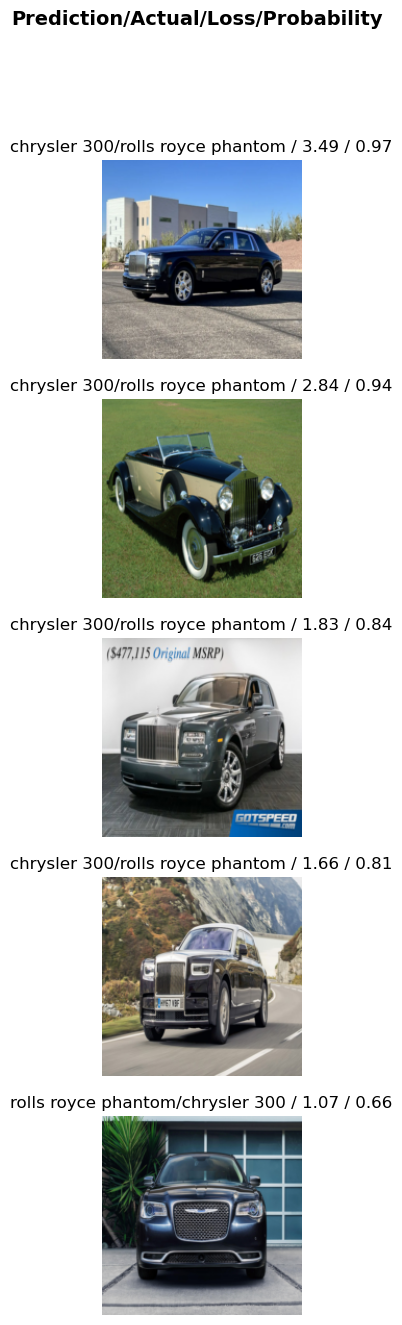

In [16]:
interp.plot_top_losses(5, nrows=5)

In [17]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner